<a href="https://colab.research.google.com/github/iptkachev/dls_part1_hw/blob/master/%5Bhw%5Dgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [66]:
# Using https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [3]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torchvision.utils as vutils
from pathlib import Path
from PIL import Image
import torch
import random
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [4]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [6]:
# !gdown --id 1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9 && unzip -qq /content/faces_dataset_small.zip

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
! unzip -qq /content/drive/MyDrive/faces_dataset_small.zip

In [16]:
# norm
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [17]:
class FacesDataset(Dataset):
  def __init__(self, root: str):
    super().__init__()
    self.file_paths = list(Path(root).rglob('*.png'))
    self.transform = tt.Compose([
      tt.Resize(image_size),
      tt.CenterCrop(image_size),
      tt.ToTensor(),
      tt.Normalize(*stats)
    ])

  def __getitem__(self, index):
    image = self._load_image(self.file_paths[index])
    return self.transform(image)

  def _load_image(self, path):
      image = Image.open(path)
      image.load()
      return image
  
  def __len__(self):
    return len(self.file_paths)

dataset = FacesDataset("/content/faces_dataset_small")

In [18]:
def get_dataloader(image_size, batch_size):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  # TODO: resize images, convert them to tensors and build dataloader
  dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
  return dataloader

In [19]:
#TODO: build dataloader and transfer it to device
dataloader = get_dataloader(image_size, batch_size)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [64]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def plot_reconstruction(images, n_examples=24, **kwargs_plot):
  clear_output(wait=True)
  fig, ax = plt.subplots(figsize=(18, 10))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images[:n_examples]).detach(), nrow=6).permute(1, 2, 0))

# Losses & scores
losses_g = []
losses_d = []
real_scores = []
fake_scores = []

def fit(dataloader, model, criterion, optimizer, epochs, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images in tqdm(dataloader):
            real_images = real_images.to(device)
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()
            
            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images).view(-1)
            real_targets = torch.ones(real_images.size(0), device=device)
            # real_noise = torch.FloatTensor(*real_targets.shape).uniform_(0, 0.2).to(device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            
            # Generate fake images and pass through discriminator
            latent = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images = model["generator"](latent)
            fake_targets = torch.zeros(fake_images.size(0), device=device)
            # fake_noise = torch.FloatTensor(*fake_targets.shape).uniform_(0, 0.05)
            fake_preds = model["discriminator"](fake_images).view(-1)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images).view(-1)
            targets = torch.ones(batch_size, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            # break

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        plot_reconstruction(fake_images.cpu())
        plt.suptitle(
            f"Epoch {epoch}: gen_loss {losses_g[-1]}, disc_loss {losses_d[-1]},"\
            f"real_score: {real_scores[-1]}, fake_score: {fake_scores[-1]}",
            fontsize=13
        )
        plt.show()
        plt.figure(figsize=(16, 7))
        plt.title("Losses")
        plt.plot(losses_g, label="generator")
        plt.plot(losses_d, label="discriminator")
        plt.legend()
        plt.show()

In [57]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [58]:
# norm
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [59]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 8, 1, 0, bias=False),  # changed kernel 4 -> 8
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)

# Create the generator
generator = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    generator = nn.DataParallel(generator, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
generator.apply(weights_init)

# Print the model
print(generator)
# inp = torch.rand(32, nz, 1, 1, device=device)
# generator(inp).shape

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(8, 8), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [60]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 4, 1, bias=False),  # changed stride 1 -> 4
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Create the Discriminator
discriminator = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    discriminator = nn.DataParallel(discriminator, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
discriminator.apply(weights_init)

# Print the model
print(discriminator)
# inp = torch.rand(32, 3, 128, 128, device=device)
# discriminator(inp).shape

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


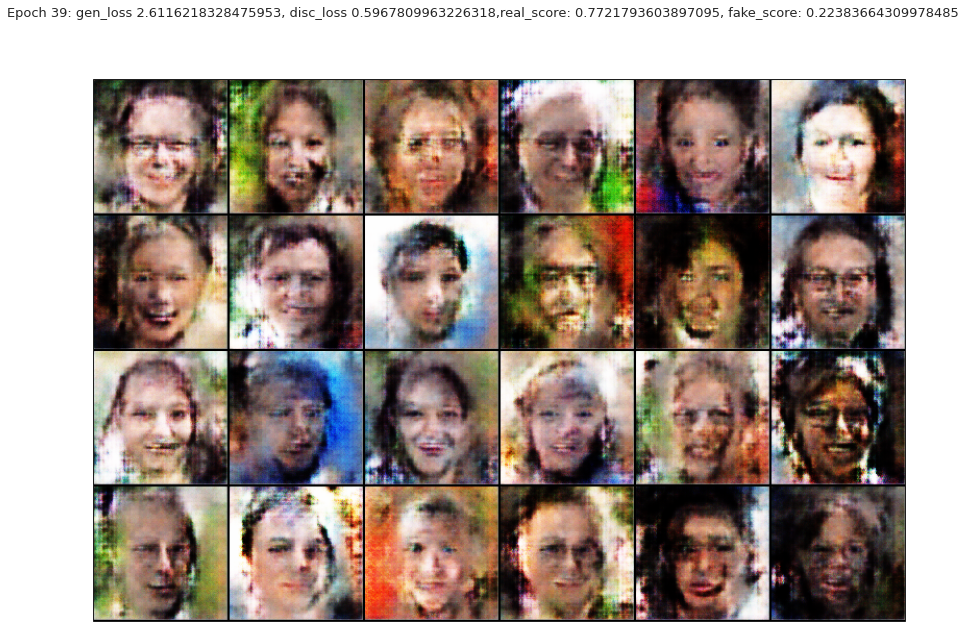

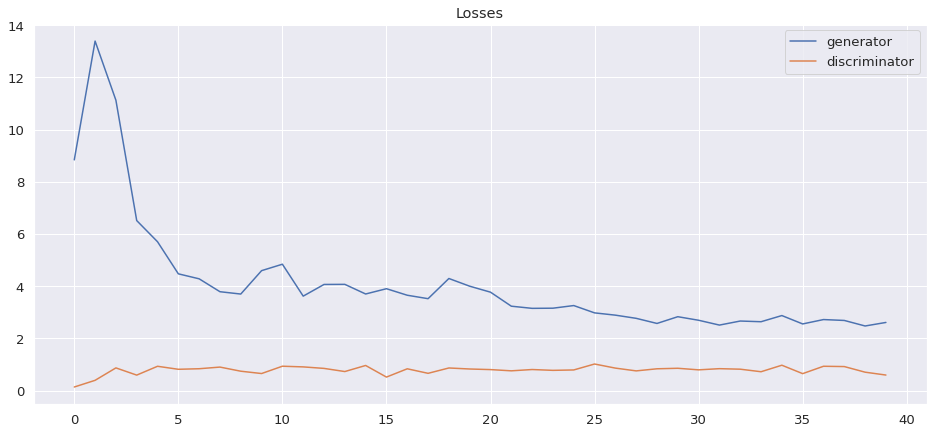

CPU times: user 3min 18s, sys: 13.3 s, total: 3min 31s
Wall time: 1h 13min 11s


In [65]:
%%time

epochs = 40
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

optimizer = {
    "discriminator": torch.optim.Adam(
        model["discriminator"].parameters(), lr=lr, betas=(beta1, 0.999)
    ),
    "generator": torch.optim.Adam(
        model["generator"].parameters(), lr=lr, betas=(beta1, 0.999)
    )
}

fit(dataloader, model, criterion, optimizer, epochs)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [71]:
n_images = 4

fixed_latent = torch.randn(n_images, nz, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [72]:
def show_images(generated):
  # TODO: show generated images
  plt.figure(figsize=(8,8))
  plt.axis("off")
  plt.title("Training Images")
  plt.imshow(np.transpose(vutils.make_grid(generated[:64], padding=2, normalize=True).cpu(),(1,2,0)))

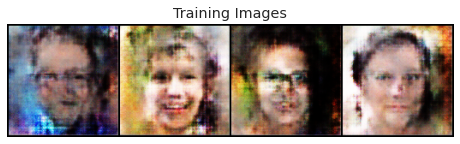

In [75]:
show_images(fake_images)

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [89]:
X, y = [], []
model["generator"].eval()
for real_images in tqdm(dataloader):
  real_images = real_images.cpu().numpy()
  X.append(real_images)
  y.append(np.ones(real_images.shape[0]))
  fixed_latent = torch.randn(batch_size, nz, 1, 1, device=device)
  fake_images = model["generator"](fixed_latent).detach().cpu().numpy()
  X.append(fake_images)
  y.append(np.zeros(fake_images.shape[0]))

  0%|          | 0/25 [00:00<?, ?it/s]

In [90]:
X = np.concatenate(X)
y = np.concatenate(y)

In [128]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

kfold = StratifiedKFold(5, shuffle=True,random_state=10)
knn = KNeighborsClassifier(n_neighbors=1)

cv_results = cross_val_score(knn, X.reshape(X.shape[0], -1), y, cv=kfold, scoring="accuracy")
print(np.mean(cv_results), np.std(cv_results))

0.8265809520000001 0.007918443896881245


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [97]:
from sklearn.manifold import TSNE

tsne = TSNE(2)
X_components = tsne.fit_transform(X.reshape(X.shape[0], -1))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [99]:
import matplotlib.pyplot as plt

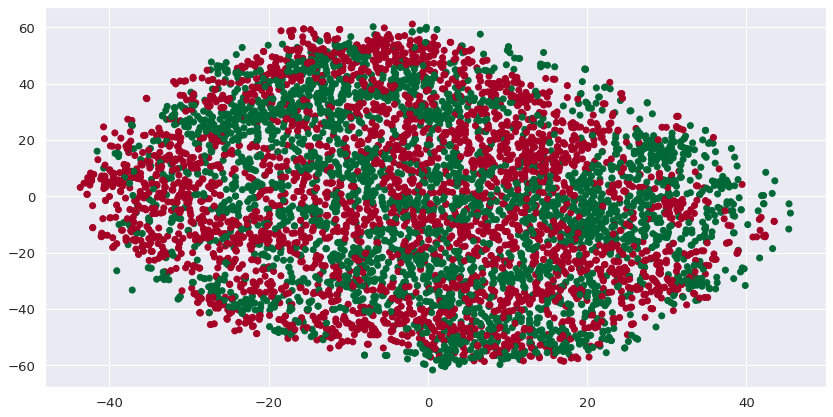

In [110]:
plt.figure(figsize=(14, 7))
plt.scatter(X_components[:, 0], X_components[:, 1], c=y, cmap='RdYlGn')


Прокомментируйте получившийся результат:

In [ ]:
# как видно из результатов выше получилась довольно высокая точность алгоритма KNeighborsClassifier, 
# что говорит о низком качестве генератора, т.к. дается довольно легко распознать 
# сгенерированные картинки от настоящих